In [1]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

/Users/ava/PycharmProjects/auto-causality/venv/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


In [2]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_effect(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 0.1 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [3]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]

### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by the auto-causality tool for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [6]:
TRUE_EFFECT = 7.5

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

data = iv_dgp_econml(n=50000, p=15, true_effect=CONSTANT_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

Xtest_constant_te = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
2081,1.0,12.804679,1.0,-0.987539,-0.549924,-0.192423,-0.051339,0.617653,-0.293630,1.024159,-0.620957,1.364169,-0.386797,-0.876347,0.084273,1.531466,-0.572508,0.743149,1.0
4329,0.0,11.180178,0.0,-1.280214,0.050470,1.322372,0.362025,-0.105957,1.673486,-1.672253,-1.355733,-0.902657,-0.440555,-1.128565,0.921231,-1.373878,-0.419580,1.226509,1.0
4151,0.0,12.395707,0.0,0.075315,-0.057688,1.065044,1.225361,1.442873,-2.444061,-0.517506,-0.743026,-0.459943,-0.473243,1.981402,-0.579994,0.530880,-0.234421,1.602286,1.0
783,1.0,14.098440,1.0,-0.416317,0.998391,0.021166,-2.619854,-0.140774,0.871997,-0.435263,0.278918,-0.275756,1.002986,0.479896,0.585253,-0.994416,-1.295810,0.152615,1.0
3810,0.0,8.150020,0.0,1.069262,-1.575730,-0.637359,-1.477574,-0.435708,0.193835,-0.558763,1.247881,-2.006386,-1.232677,1.027241,-1.637683,-0.593128,1.092633,1.240681,0.0


For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Ward's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [36]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV"]

ac_constant_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=120,
    propensity_model="dummy",
)

ac_constant_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


 We get the estimated effect for the best estimator by energy distance score

In [8]:
# score all estimators on the test set
def score_all_test(models):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            scr['scores']['test'] = models.scorer.make_scores(causal_estimate, test_df, problem=ac.problem, metrics_to_report=ac.metrics_to_report)
        except:
            pass

def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [21]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_scores.append([est_name, est_effect, (est_effect-te)**2])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse"])


In [30]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


First we see the estimated effect for each model, and respective MSE compared with true effect

In [24]:
get_est_effects(ac_constant_te, Xtest_constant_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,7.475368,0.000607
1,iv.econml.iv.dml.DMLIV,3.743179,14.113707
2,iv.econml.iv.dml.OrthoIV,7.574516,0.005553
3,iv.econml.iv.dr.LinearDRIV,3.791014,13.756576
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.507574,0.000057
5,iv.econml.iv.dr.SparseLinearDRIV,5.705097,3.221677


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

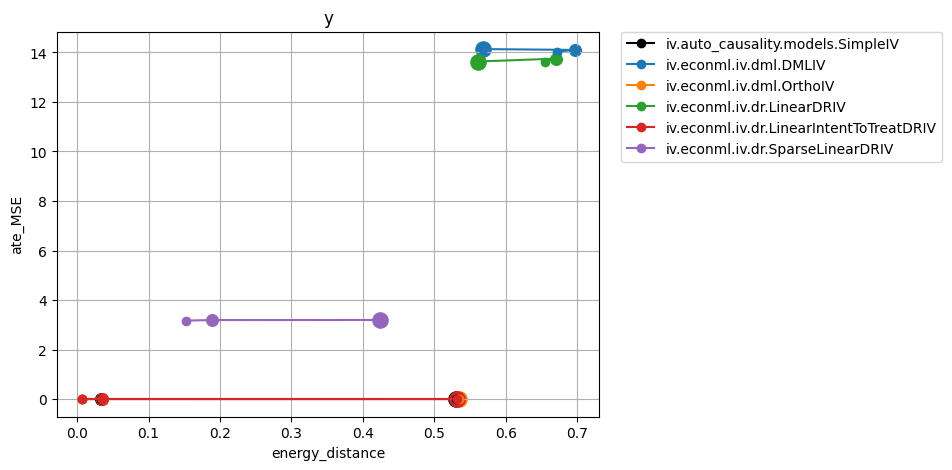

In [31]:
score_all_test(ac_constant_te)
graph_compare_estimators(ac_constant_te)

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [13]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] + X[:, 7])

data = iv_dgp_econml(n=5000, p=15, true_effect=LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

Xtest_linear_te = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
476,0.0,4.156738,1.0,-1.151120,-0.341043,-0.192166,-0.211528,1.568461,0.450164,0.436224,0.976537,-0.361160,1.397600,0.209632,-1.412590,0.011914,-0.535702,-0.704933,0.0
3239,1.0,17.358908,1.0,0.468839,-0.643806,-0.126693,4.722913,0.929081,0.105032,-0.655209,0.486633,-0.189825,-0.998314,-0.054959,-0.720656,0.803423,-1.784907,0.419442,1.0
613,0.0,9.153475,0.0,1.047092,-0.972918,0.122322,0.661225,-0.804772,-0.142957,0.425869,-1.680813,-0.618027,0.408714,-0.272679,-0.460878,0.664304,-0.356103,0.426782,1.0
4770,0.0,4.351648,0.0,-0.286730,-1.337752,-0.038457,-1.290970,0.780953,-0.131588,-0.192165,-0.230882,0.089163,0.521245,0.030602,-1.166620,-0.125632,0.279105,0.466312,1.0
2272,1.0,3.729948,1.0,-1.535214,-0.681066,0.671984,-1.860252,1.258648,0.063771,1.789265,-1.357620,1.170905,0.141171,0.347550,-0.594062,1.815731,-0.828970,1.070730,0.0


In [34]:
ac_linear_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=120,
    propensity_model="dummy",
)

ac_linear_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)

In [25]:
get_est_effects(ac_linear_te, Xtest_linear_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,0.409788,50.271103
1,iv.econml.iv.dml.DMLIV,-0.021106,56.567042
2,iv.econml.iv.dml.OrthoIV,0.105579,54.677467
3,iv.econml.iv.dr.LinearDRIV,0.022670,55.910463
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,0.284875,52.058026
5,iv.econml.iv.dr.SparseLinearDRIV,0.162762,53.835059


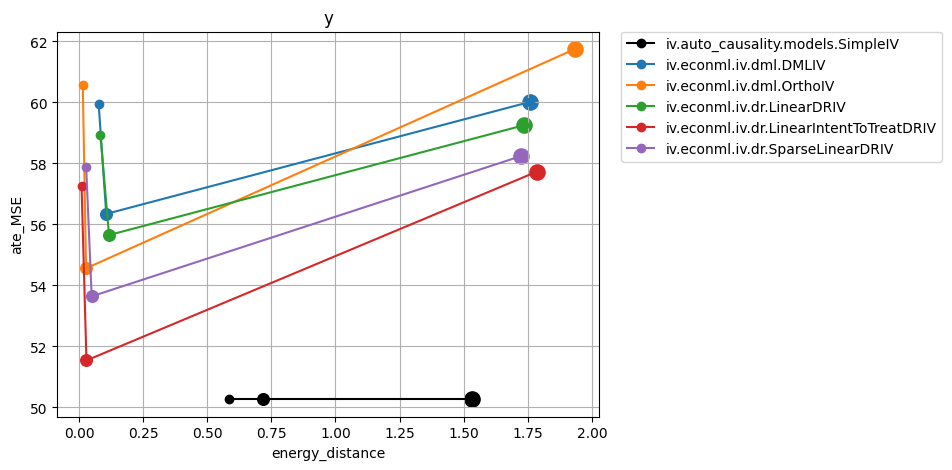

In [32]:
score_all_test(ac_linear_te)
graph_compare_estimators(ac_linear_te)

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [17]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2)

data = iv_dgp_econml(n=5000, p=15, true_effect=QUADRATIC_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
4883,0.0,5.642340,0.0,-0.166649,-0.037972,-2.462183,-0.661645,-1.274812,2.164241,-1.327964,-0.051017,0.313797,-0.090737,-0.743466,0.387685,0.239865,1.189409,-2.573799,0.0
2386,0.0,2.351887,1.0,-1.471137,0.640296,0.966827,-0.630309,2.840237,-1.403959,0.993368,-0.772781,-0.332158,-0.068102,-1.589545,-0.451900,-0.904239,-0.666099,-0.479209,1.0
4030,0.0,4.001770,1.0,-0.561018,0.464426,1.549468,-0.208957,-0.813260,-0.340804,0.438366,-0.605109,-0.281733,1.120829,0.689588,1.295571,1.067522,0.424703,-0.668093,0.0
2448,0.0,8.935736,0.0,-0.841337,0.889617,-0.589731,0.392965,-0.811575,-2.079406,-0.308424,-0.056356,2.167229,-0.510654,-0.144820,0.903875,0.287287,2.137014,-0.863859,1.0
3809,0.0,5.696070,0.0,-0.849518,0.074309,0.024217,0.373959,-0.040285,0.633923,0.904897,0.516027,0.547131,0.387320,1.336018,-0.242165,-0.037972,-1.099770,-0.093276,1.0


In [35]:
ac_quad_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=120,
    propensity_model="dummy",
)

ac_quad_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


In [26]:
get_est_effects(ac_quad_te, Xtest)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,7.573547,0.005409
1,iv.econml.iv.dml.DMLIV,3.591073,15.279712
2,iv.econml.iv.dml.OrthoIV,7.395235,0.010976
3,iv.econml.iv.dr.LinearDRIV,3.757597,14.005577
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.432717,0.004527
5,iv.econml.iv.dr.SparseLinearDRIV,5.355130,4.600468


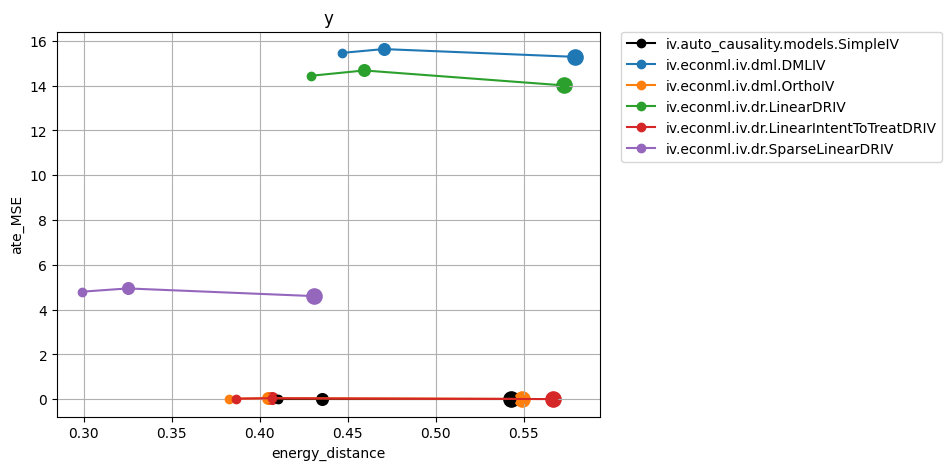

In [33]:
score_all_test(ac_quad_te)
graph_compare_estimators(ac_quad_te)
